# Preprocess Non-textual Data

In [1]:
# # Check module locations if required
# import sys
# import pprint
# pprint.pprint(sys.path)

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import os
import io
from lxml import etree
from dateutil.relativedelta import *

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import pickle
from tqdm.notebook import tqdm
import re

In [3]:
# Set display preference (Optional)
plt.rcParams["figure.figsize"] = (18,9)
plt.style.use('fivethirtyeight')
sns.set(style='white', context='notebook', palette='deep')

pd.options.display.max_rows = 20
pd.options.display.max_seq_items = 50
pd.set_option('display.max_colwidth', 200)

## Load FOMC Meeting
### Chairpersons

In [4]:
# FOMC Chairperson's list
chairpersons = pd.DataFrame(
    data=[["Volcker", "Paul", dt.datetime(1979,8,6), dt.datetime(1987,8,10)],
          ["Greenspan", "Alan", dt.datetime(1987,8,11), dt.datetime(2006,1,31)], 
          ["Bernanke", "Ben", dt.datetime(2006,2,1), dt.datetime(2014,1,31)], 
          ["Yellen", "Janet", dt.datetime(2014,2,3), dt.datetime(2018,2,3)],
          ["Powell", "Jerome", dt.datetime(2018,2,5), dt.datetime(2022,2,5)]],
    columns=["Surname", "FirstName", "FromDate", "ToDate"])
chairpersons

,Surname,FirstName,FromDate,ToDate
0,Volcker,Paul,1979-08-06,1987-08-10
1,Greenspan,Alan,1987-08-11,2006-01-31
2,Bernanke,Ben,2006-02-01,2014-01-31
3,Yellen,Janet,2014-02-03,2018-02-03
4,Powell,Jerome,2018-02-05,2022-02-05


In [5]:
def get_chairperson(x):
    '''
    Return a tuple of chairperson's Fullname for the given date x.
    '''
    # If x is string, convert to datetime
    if type(x) is str:
        try:
            x = dt.datetime.strftime(x, '%Y-%m-%d')
        except:
            return None
    
    chairperson = chairpersons.loc[chairpersons['FromDate'] <= x].loc[x <= chairpersons['ToDate']]
    return list(chairperson.FirstName)[0] + " " + list(chairperson.Surname)[0]

### Load Calendar

In [6]:
file = open('../data/FOMC/fomc_calendar.pickle', 'rb')

fomc_calendar = pd.read_pickle(file)
file.close()

print(fomc_calendar.shape)
fomc_calendar

(446, 4)


,date,unscheduled,forecast,confcall
0,1980-01-09,False,False,False
1,1980-02-05,False,False,False
2,1980-02-22,False,False,True
3,1980-03-07,False,False,True
4,1980-03-18,False,False,False
...,...,...,...,...
441,2022-06-15,False,True,False
442,2022-07-27,False,False,False
443,2022-09-21,False,True,False
444,2022-11-02,False,False,False


In [7]:
# Take data after 1982/09/27
fomc_calendar = fomc_calendar.loc[fomc_calendar['date'] >= dt.datetime(1982, 9, 27)]

# Use date as index
fomc_calendar.set_index('date', inplace=True)
fomc_calendar.head()

,unscheduled,forecast,confcall
date,,,
1982-10-05,False,False,False
1982-11-16,False,False,False
1982-12-21,False,False,False
1983-01-14,False,False,True
1983-01-21,False,False,True


### Add Chairperson to Calendar

In [8]:
fomc_calendar['ChairPerson'] = fomc_calendar.index.map(get_chairperson)
fomc_calendar

IndexError: list index out of range

## Load Market Data

#### Download from Quandl
Quandl provide APIs and library for each data access to multiple sources.
Created a python function to download data, so please execute it first. api_key can be found on your Quandl Account.

` python QuandlGetData.py [api_key] 1980-01-01 `

Also, it can be accessed via Web API.
```
import quandl
import getpass

# Enter Quandle API Key
quandl.ApiConfig.api_key = getpass.getpass('Enter your API Key for Quandl')

data = quandl.get("FRED/DFEDTAR", start_date="1980-01-01")
```

In [9]:
# FRB changed to range from 2008. So use lower side from 2008 as facing lower bound of zero.
filename_till08 = '../data/MarketData/Quandl/FRED_DFEDTAR.csv'
filename_from08u = '../data/MarketData/Quandl/FRED_DFEDTARU.csv'
filename_from08l = '../data/MarketData/Quandl/FRED_DFEDTARL.csv'

fedtar = pd.read_csv(filename_till08, names=['Date', 'Rate'], header=0)
fedtaru = pd.read_csv(filename_from08u, names=['Date', 'Rate'], header=0)
fedtarl = pd.read_csv(filename_from08l, names=['Date', 'Rate'], header=0)
fedrate_df = pd.concat([fedtar, fedtarl], axis=0)
fedrate_df.index = pd.to_datetime(fedrate_df.Date, format="%Y-%m-%d")
fedrate_df.drop(columns=['Date'], inplace=True)
fedrate_df['Rate'] = fedrate_df['Rate'].map(lambda x: np.float(x))
# Add difference from previous value
fedrate_df['diff'] = fedrate_df['Rate'].diff()

fedrate_df

/var/folders/mb/399h735x1zs3yswdfj_tqm68jcd560/T/ipykernel_13013/1461422323.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fedrate_df['Rate'] = fedrate_df['Rate'].map(lambda x: np.float(x))


,Rate,diff
Date,,
1982-09-27,10.25,NaN
1982-09-28,10.25,0.00
1982-09-29,10.25,0.00
1982-09-30,10.25,0.00
1982-10-01,10.00,-0.25
...,...,...
2022-01-15,0.00,0.00
2022-01-16,0.00,0.00
2022-01-17,0.00,0.00


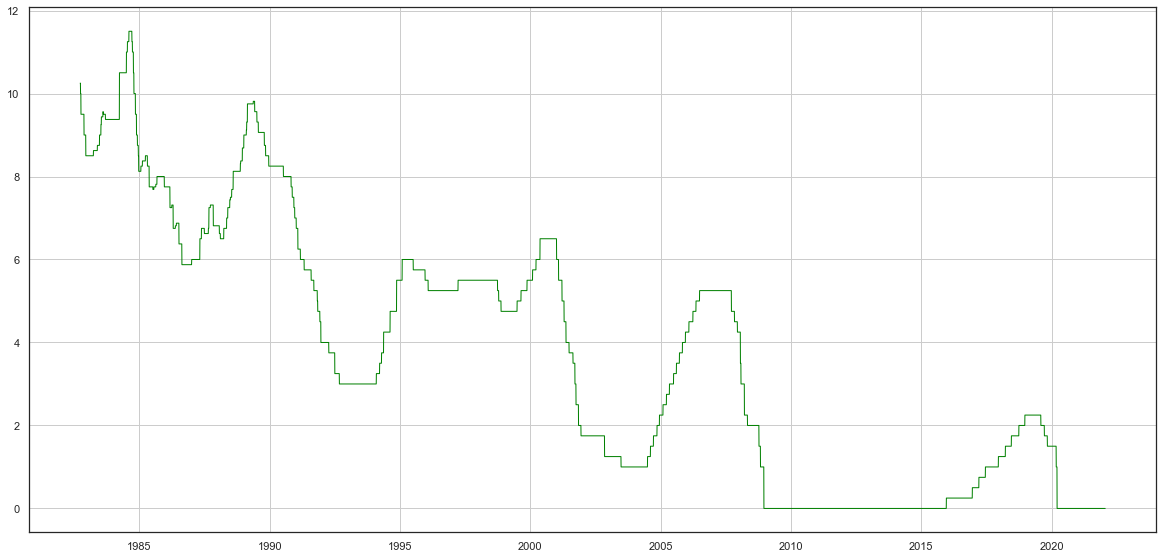

In [10]:
fig, ax = plt.subplots()
ax.plot(fedrate_df.index, fedrate_df['Rate'].values, 
         c = 'green',
         linewidth= 1.0)
ax.grid(True)
plt.show()

### Effective FED Rate

In [11]:
# Load FED Effective

filename = '../data/MarketData/Quandl/FRED_DFF.csv'

dff = pd.read_csv(filename, names=['DATE', 'DFF'], header=0)
dff = dff.set_index(pd.to_datetime(dff['DATE'], format="%Y-%m-%d")).drop(columns=['DATE'])
# Add difference from previous value
dff['diff'] = dff['DFF'].diff()
dff

,DFF,diff
DATE,,
1980-01-01,14.77,NaN
1980-01-02,14.00,-0.77
1980-01-03,13.89,-0.11
1980-01-04,14.00,0.11
1980-01-05,14.00,0.00
...,...,...
2022-01-15,0.08,0.00
2022-01-16,0.08,0.00
2022-01-17,0.08,0.00


(512, 2)


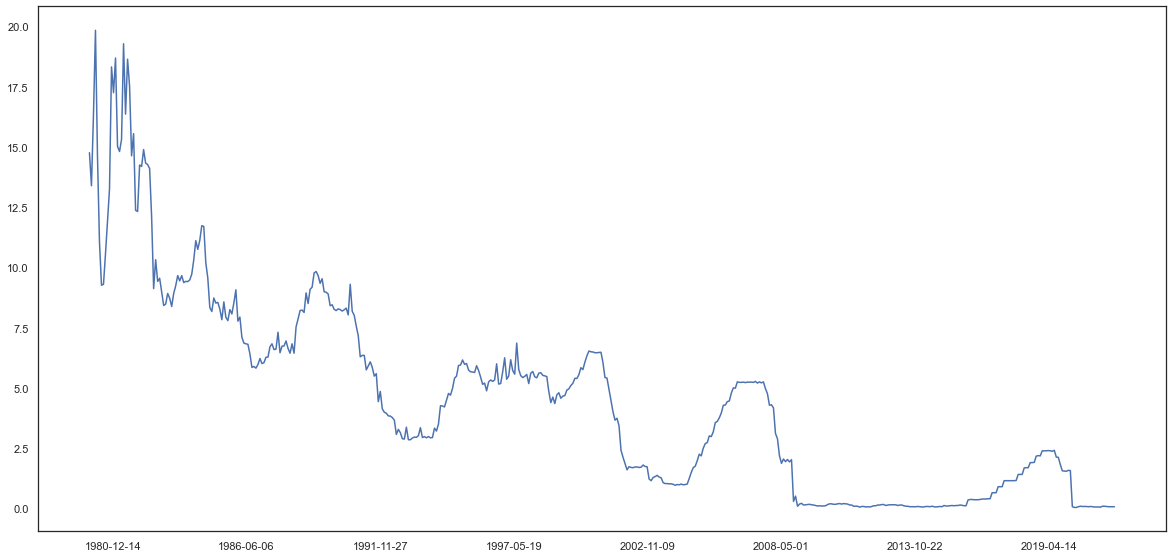

In [12]:
# Use every 30th row as it has too many data points
dff_30 = dff.iloc[::30, :]
print(dff_30.shape)

fig, ax = plt.subplots()
ax.plot(dff_30.index.values, dff_30['DFF'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

## Load Economic Indices

### GDP

Real GDP, Quarterly announced

In [13]:
# Load Real GDP
# Billions of Chained 2012 Dollars, Seasonally Adjusted Annual Rate

filename = '../data/MarketData/Quandl/FRED_GDPC1.csv'

gdpc1 = pd.read_csv(filename, names=['DATE', 'GDPC1'], header=0)
gdpc1 = gdpc1.set_index(pd.to_datetime(gdpc1['DATE'], format="%Y-%m-%d")).drop(columns=['DATE'])
# Add difference from previous value
gdpc1['diff_prev'] = gdpc1['GDPC1'].diff() / gdpc1['GDPC1'].shift(1) * 100
gdpc1['diff_year'] = gdpc1['GDPC1'].diff(periods=4) / gdpc1['GDPC1'].shift(4) * 100
gdpc1

,GDPC1,diff_prev,diff_year
DATE,,,
1980-01-01,6842.024,NaN,NaN
1980-04-01,6701.046,-2.060472,NaN
1980-07-01,6693.082,-0.118847,NaN
1980-10-01,6817.903,1.864926,NaN
1981-01-01,6951.495,1.959429,1.599980
...,...,...,...
2020-07-01,18560.774,7.547535,-2.887506
2020-10-01,18767.778,1.115277,-2.262915
2021-01-01,19055.655,1.533890,0.546977


In [14]:
gdpc1

,GDPC1,diff_prev,diff_year
DATE,,,
1980-01-01,6842.024,NaN,NaN
1980-04-01,6701.046,-2.060472,NaN
1980-07-01,6693.082,-0.118847,NaN
1980-10-01,6817.903,1.864926,NaN
1981-01-01,6951.495,1.959429,1.599980
...,...,...,...
2020-07-01,18560.774,7.547535,-2.887506
2020-10-01,18767.778,1.115277,-2.262915
2021-01-01,19055.655,1.533890,0.546977


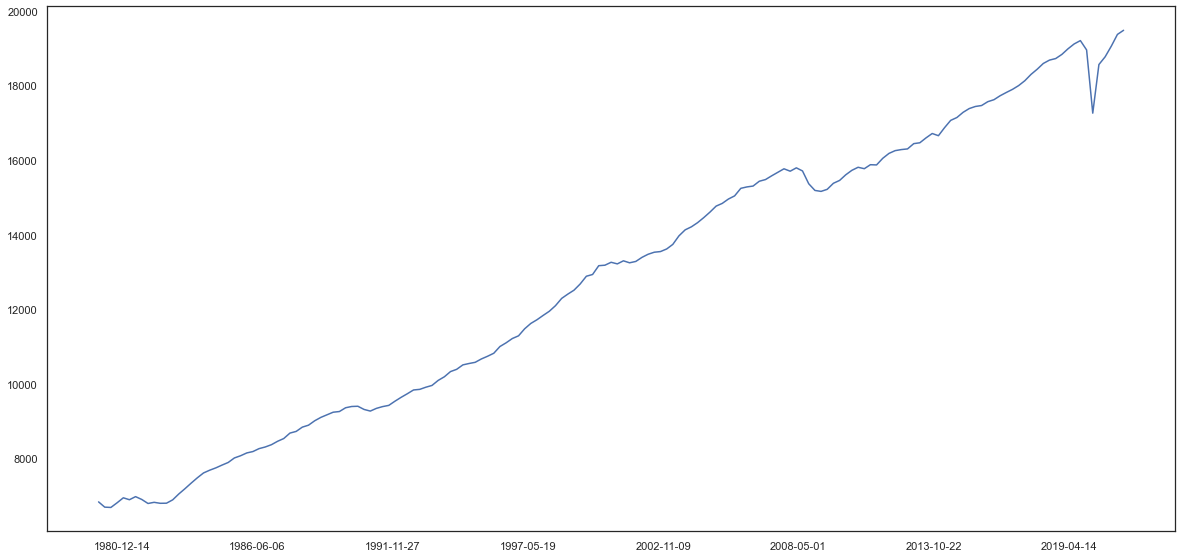

In [15]:
fig, ax = plt.subplots()
ax.plot(gdpc1.index.values, gdpc1['GDPC1'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

### Potential GDP

In [16]:
# Load Real Potential GDP
# Billions of Chained 2012 Dollars, Not Seasonally Adjusted

filename = '../data/MarketData/Quandl/FRED_GDPPOT.csv'

gdppot = pd.read_csv(filename, names=['DATE', 'GDPPOT'], header=0)
gdppot = gdppot.set_index(pd.to_datetime(gdppot['DATE'], format="%Y-%m-%d")).drop(columns=['DATE'])
# Add difference from previous value
gdppot['diff_prev'] = gdppot['GDPPOT'].diff() / gdppot['GDPPOT'].shift(1) * 100
gdppot['diff_year'] = gdppot['GDPPOT'].diff(periods=4) / gdppot['GDPPOT'].shift(4) * 100
gdppot

,GDPPOT,diff_prev,diff_year
DATE,,,
1980-01-01,6847.481683,NaN,NaN
1980-04-01,6890.146039,0.623066,NaN
1980-07-01,6928.061362,0.550283,NaN
1980-10-01,6968.010712,0.576631,NaN
1981-01-01,7012.104757,0.632807,2.404140
...,...,...,...
2030-10-01,23423.370000,0.423458,1.708386
2031-01-01,23522.550000,0.423423,1.706249
2031-04-01,23622.050000,0.422998,1.704632


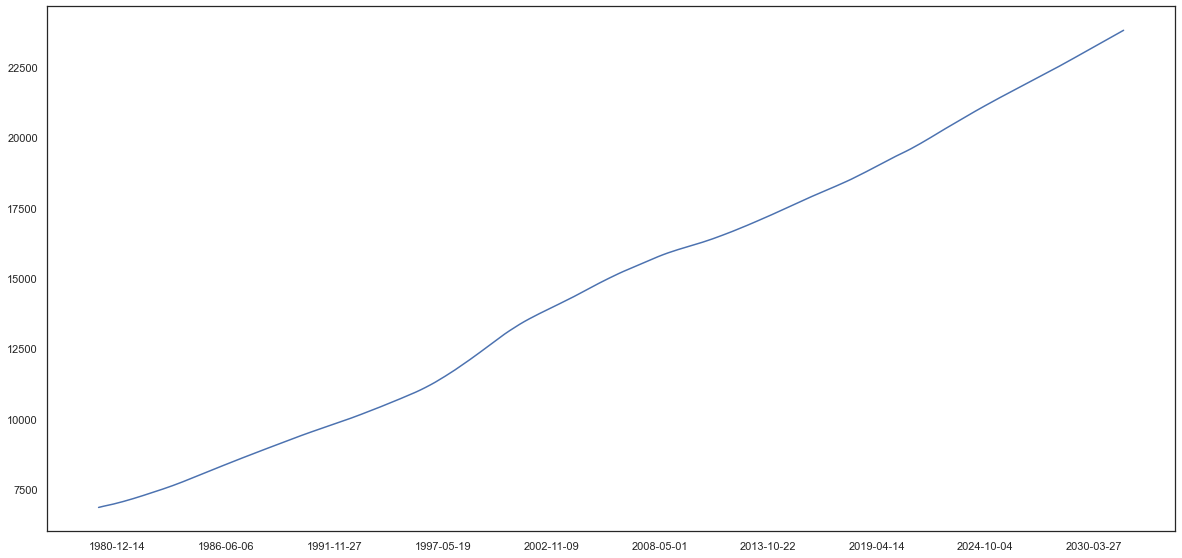

In [17]:
fig, ax = plt.subplots()
ax.plot(gdppot.index.values, gdppot['GDPPOT'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

### Personal Consumption: PCE

Use Core PCE excluding Food and Energy as FRB takes this index as important indicator. <BR />
It is announced monthly around the last working days of each month for the previous month.

In [18]:
# Load Personal Consumption Expenditures Excluding Food and Energy (Chain-Type Price Index)
# Index 2012=100, Seasonally Adjusted

filename = '../data/MarketData/Quandl/FRED_PCEPILFE.csv'

pcepilfe = pd.read_csv(filename, names=['DATE', 'PCEPILFE'], header=0)
pcepilfe = pcepilfe.set_index(pd.to_datetime(pcepilfe['DATE'], format="%Y-%m-%d")).drop(columns=['DATE'])
# Add difference from previous value
pcepilfe['diff_prev'] = pcepilfe['PCEPILFE'].diff() / pcepilfe['PCEPILFE'].shift(1) * 100
pcepilfe['diff_year'] = pcepilfe['PCEPILFE'].diff(periods=12) / pcepilfe['PCEPILFE'].shift(12) * 100
pcepilfe

,PCEPILFE,diff_prev,diff_year
DATE,,,
1980-01-01,39.095,NaN,NaN
1980-02-01,39.485,0.997570,NaN
1980-03-01,39.851,0.926934,NaN
1980-04-01,40.056,0.514416,NaN
1980-05-01,40.378,0.803875,NaN
...,...,...,...
2021-07-01,117.704,0.321324,3.603556
2021-08-01,118.073,0.313498,3.599161
2021-09-01,118.357,0.240529,3.702763


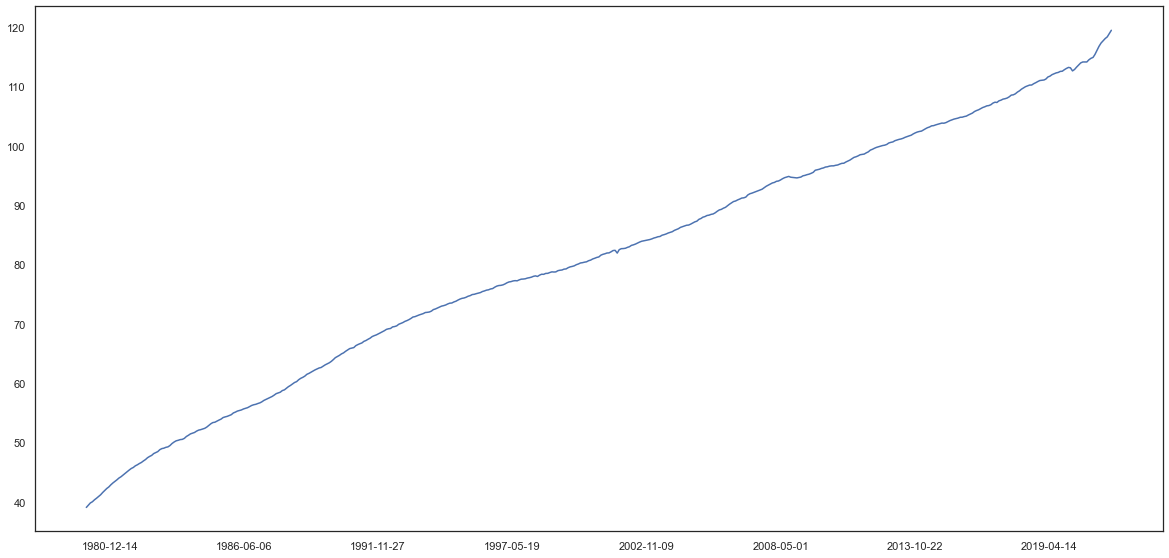

In [19]:
fig, ax = plt.subplots()
ax.plot(pcepilfe.index.values, pcepilfe['PCEPILFE'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

### Personal Consumption: CPI

CPI's coverage is less than PCE but announced monthly around 10th of each month for the previous month, which is earlier than PCE. <BR />
As this is available to some meetings even before PCE announcement, take this index as well.

In [20]:
# Load Consumer Price Index for All Urban Consumers: All Items in U.S. City Average
# Index 1982-1984=100, Seasonally Adjusted

filename = '../data/MarketData/Quandl/FRED_CPIAUCSL.csv'

cpiaucsl = pd.read_csv(filename, names=['DATE', 'CPIAUCSL'], header=0)
cpiaucsl = cpiaucsl.set_index(pd.to_datetime(cpiaucsl['DATE'], format="%Y-%m-%d")).drop(columns=['DATE'])
# Add difference from previous value
cpiaucsl['diff_prev'] = cpiaucsl['CPIAUCSL'].diff() / cpiaucsl['CPIAUCSL'].shift(1) * 100
cpiaucsl['diff_year'] = cpiaucsl['CPIAUCSL'].diff(periods=12) / cpiaucsl['CPIAUCSL'].shift(12) * 100
cpiaucsl


,CPIAUCSL,diff_prev,diff_year
DATE,,,
1980-01-01,78.000,NaN,NaN
1980-02-01,79.000,1.282051,NaN
1980-03-01,80.100,1.392405,NaN
1980-04-01,80.900,0.998752,NaN
1980-05-01,81.700,0.988875,NaN
...,...,...,...
2021-08-01,273.012,0.274365,5.202477
2021-09-01,274.138,0.412436,5.377303
2021-10-01,276.724,0.943321,6.243521


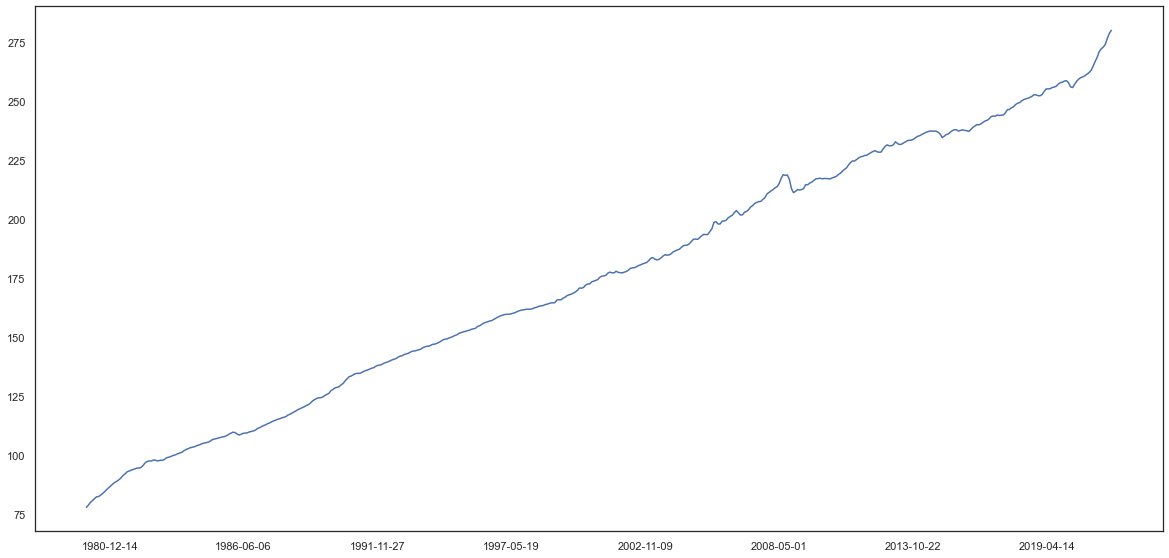

In [21]:
fig, ax = plt.subplots()
ax.plot(cpiaucsl.index.values, cpiaucsl['CPIAUCSL'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

### Unemployment

Takes unemployment rate as important input for FRB's decision. Real Potential GDP is quarterly and usually two month after each quarter. On the other hand, unemployment is annnounced monthly, around a week after the end of each month and can be more real-time. <BR />
As bigger number indicates negative, turn the sign to have negative number.

In [22]:
# Load Unemployment
# Percent, Seasonally Adjusted

filename = '../data/MarketData/Quandl/FRED_UNRATE.csv'

unrate = pd.read_csv(filename, names=['DATE', 'UNRATE'], header=0)
unrate = unrate.set_index(pd.to_datetime(unrate['DATE'], format="%Y-%m-%d")).drop(columns=['DATE'])
unrate['UNRATE'] = unrate['UNRATE'] * -1
# Add difference from previous value
unrate['diff_prev'] = unrate['UNRATE'].diff()
unrate['diff_year'] = unrate['UNRATE'].diff(periods=12)
unrate

,UNRATE,diff_prev,diff_year
DATE,,,
1980-01-01,-6.3,NaN,NaN
1980-02-01,-6.3,0.0,NaN
1980-03-01,-6.3,0.0,NaN
1980-04-01,-6.9,-0.6,NaN
1980-05-01,-7.5,-0.6,NaN
...,...,...,...
2021-08-01,-5.2,0.2,3.2
2021-09-01,-4.7,0.5,3.2
2021-10-01,-4.6,0.1,2.3


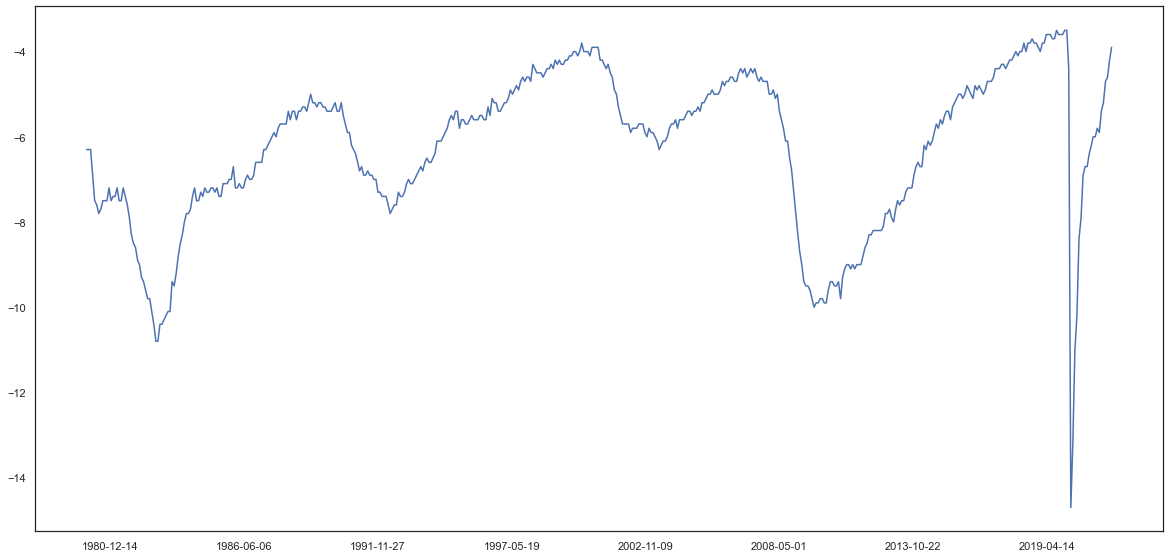

In [23]:
fig, ax = plt.subplots()
ax.plot(unrate.index.values, unrate['UNRATE'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

### Employment

In [24]:
# Load Employment
# Seasonally Adjusted

filename = '../data/MarketData/Quandl/FRED_PAYEMS.csv'

payems = pd.read_csv(filename, names=['DATE', 'PAYEMS'], header=0)
payems = payems.set_index(pd.to_datetime(payems['DATE'], format="%Y-%m-%d")).drop(columns=['DATE'])
# Add difference from previous value
payems['diff_prev'] = payems['PAYEMS'].diff()
payems['diff_year'] = payems['PAYEMS'].diff(periods=12)
payems

,PAYEMS,diff_prev,diff_year
DATE,,,
1980-01-01,90800.0,NaN,NaN
1980-02-01,90883.0,83.0,NaN
1980-03-01,90994.0,111.0,NaN
1980-04-01,90849.0,-145.0,NaN
1980-05-01,90420.0,-429.0,NaN
...,...,...,...
2021-08-01,147476.0,483.0,6327.0
2021-09-01,147855.0,379.0,5990.0
2021-10-01,148503.0,648.0,5958.0


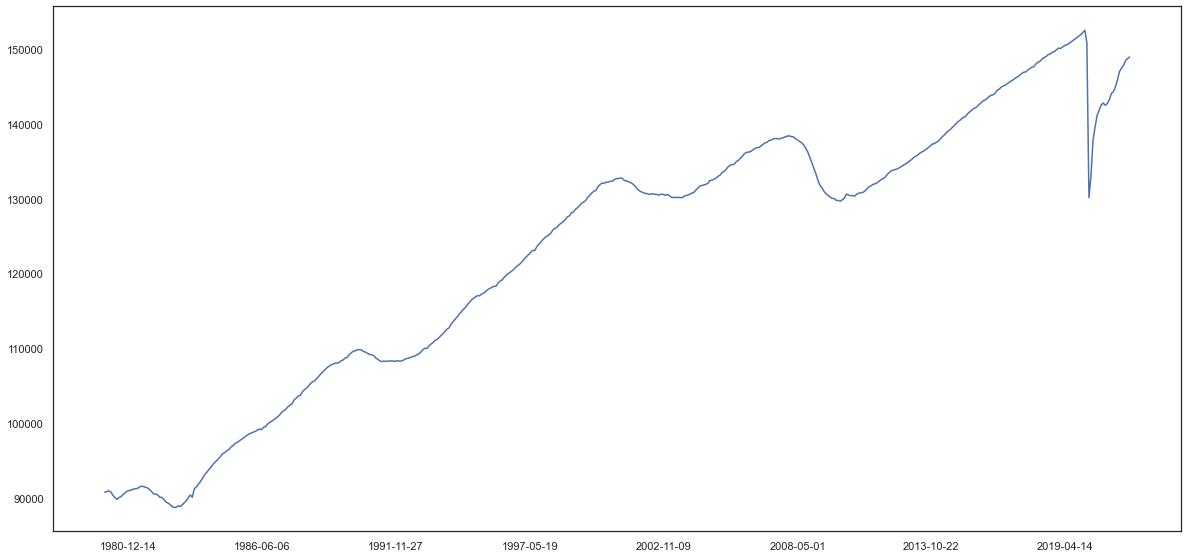

In [25]:
fig, ax = plt.subplots()
ax.plot(payems.index.values, payems['PAYEMS'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

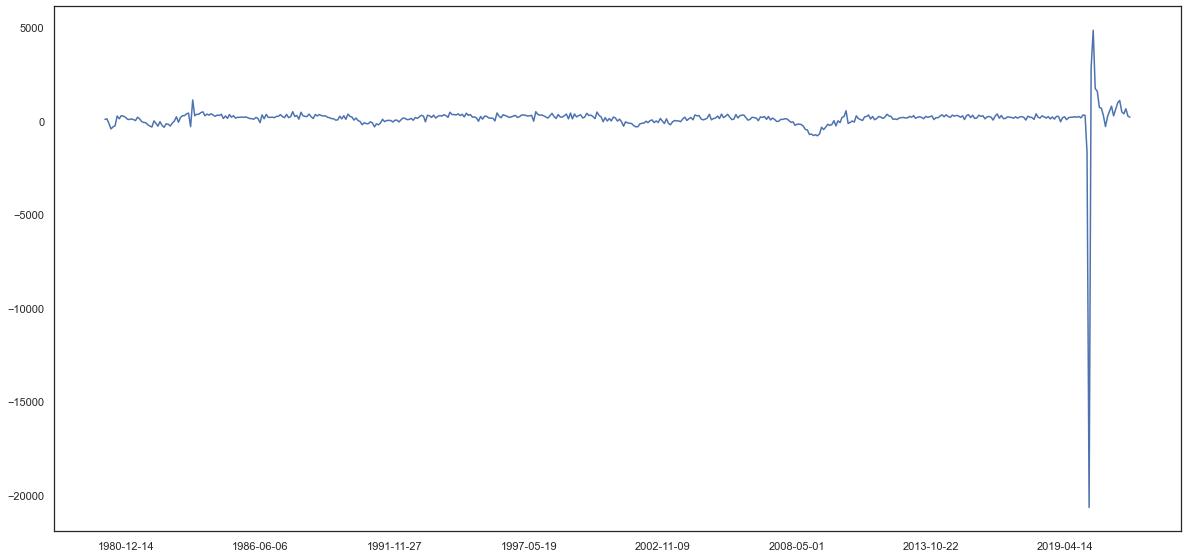

In [26]:
fig, ax = plt.subplots()
ax.plot(payems.index.values, payems['diff_prev'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

### ISM Purchasing Managers Index / Non-manufacturing Index

Another important indicator of the economy, also announced monthly right after the end of each month.

In [27]:
# Load ISM PMI
filename = '../data/MarketData/Quandl/ISM_MAN_PMI.csv'

ism_pmi = pd.read_csv(filename, names=['Date', 'PMI'], header=0)
ism_pmi = ism_pmi.sort_values(by=['Date'], ascending=True)
ism_pmi = ism_pmi.set_index(pd.to_datetime(ism_pmi['Date'], format="%Y-%m-%d")).drop(columns=['Date'])
# Add difference from previous value
ism_pmi['diff_prev'] = ism_pmi['PMI'].diff()
ism_pmi['diff_year'] = ism_pmi['PMI'].diff(periods=12)
ism_pmi

,PMI,diff_prev,diff_year
Date,,,
1980-01-01,46.2,NaN,NaN
1980-02-01,50.2,4.0,NaN
1980-03-01,43.6,-6.6,NaN
1980-04-01,37.4,-6.2,NaN
1980-05-01,29.4,-8.0,NaN
...,...,...,...
2021-08-01,59.9,0.4,4.3
2021-09-01,61.1,1.2,5.4
2021-10-01,60.8,-0.3,2.0


In [28]:
# Load ISM NMI
filename = '../data/MarketData/Quandl/ISM_NONMAN_NMI.csv'

ism_nmi = pd.read_csv(filename, names=['Date', 'NMI'], header=0)
ism_nmi = ism_nmi.sort_values(by=['Date'], ascending=True)
ism_nmi.columns = ['Date', 'NMI']
ism_nmi = ism_nmi.set_index(pd.to_datetime(ism_nmi['Date'], format="%Y-%m-%d")).drop(columns=['Date'])
# Add difference from previous value
ism_nmi['diff_prev'] = ism_nmi['NMI'].diff()
ism_nmi['diff_year'] = ism_nmi['NMI'].diff(periods=12)
ism_nmi

,NMI,diff_prev,diff_year
Date,,,
2008-01-01,45.0,NaN,NaN
2008-02-01,49.9,4.9,NaN
2008-03-01,49.4,-0.5,NaN
2008-04-01,51.8,2.4,NaN
2008-05-01,51.4,-0.4,NaN
...,...,...,...
2021-08-01,61.7,-2.4,4.5
2021-09-01,61.9,0.2,4.7
2021-10-01,66.7,4.8,10.5


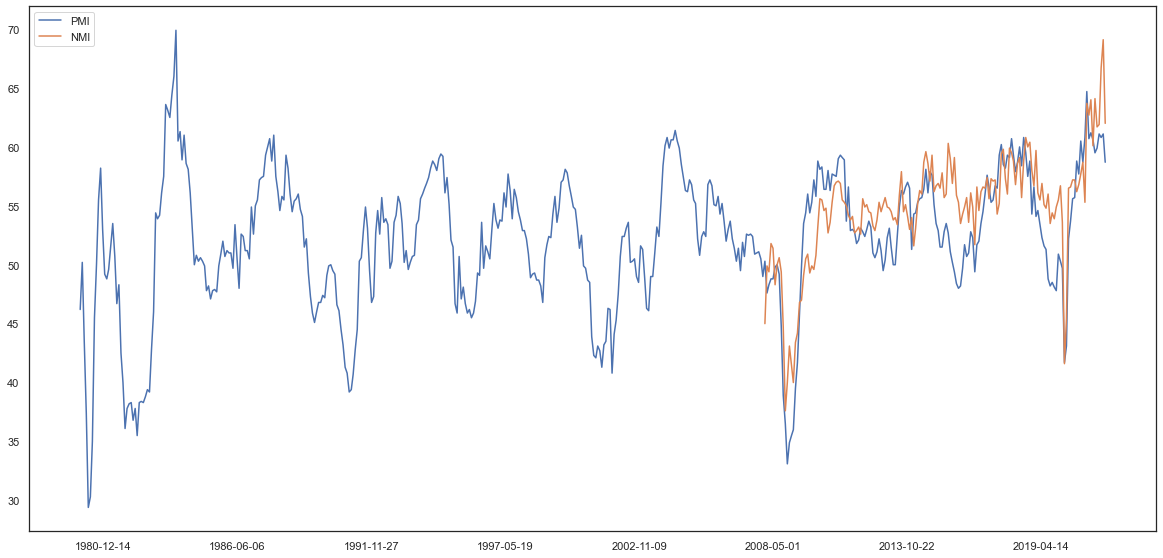

In [29]:
fig, ax = plt.subplots()
ax.plot(ism_pmi.index.values, ism_pmi['PMI'].values)
ax.plot(ism_nmi.index.values, ism_nmi['NMI'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
ax.legend(['PMI', 'NMI'])
plt.show()


Non-manufacturing index (NMI) is available only post 2008. <br /> It cannot cover a lot percentage of the target period, decided not to use it.

### Retail Sales
Retail sales is an important indicator of the current economic situation.
It is usually announced around the middle of each month (15th) for the previous month.

In [30]:
# Load Advance Real Retail and Food Services Sales
# Millions of 1982-84 CPI Adjusted Dollars, Seasonally Adjusted

filename = '../data/MarketData/Quandl/FRED_RRSFS.csv'

rrsfs = pd.read_csv(filename, names=['DATE', 'RRSFS'], header=0)
rrsfs = rrsfs.set_index(pd.to_datetime(rrsfs['DATE'], format="%Y-%m-%d")).drop(columns=['DATE'])
# Add difference from previous value
rrsfs['diff_prev'] = rrsfs['RRSFS'].diff() / rrsfs['RRSFS'].shift(1) * 100
rrsfs['diff_year'] = rrsfs['RRSFS'].diff(periods=12) / rrsfs['RRSFS'].shift(12) * 100
rrsfs


,RRSFS,diff_prev,diff_year
DATE,,,
1992-01-01,118651.0,NaN,NaN
1992-02-01,118480.0,-0.144120,NaN
1992-03-01,117700.0,-0.658339,NaN
1992-04-01,118156.0,0.387426,NaN
1992-05-01,118548.0,0.331765,NaN
...,...,...,...
2021-08-01,227969.0,0.882398,9.967922
2021-09-01,228717.0,0.328115,8.338149
2021-10-01,230591.0,0.819353,9.413434


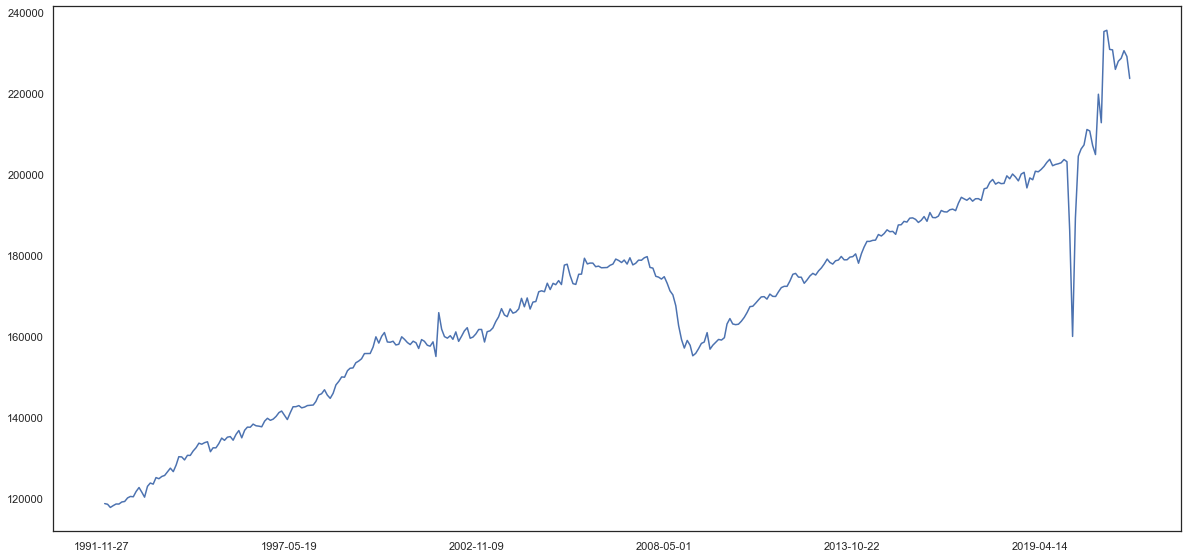

In [31]:
fig, ax = plt.subplots()
ax.plot(rrsfs.index.values, rrsfs['RRSFS'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

### New Home Sales
New home sales is another important index to know the retail sales figure. <br />
It is usually announced around a week before the end of each month for the previous month.

In [32]:
filename = '../data/MarketData/Quandl/FRED_HSN1F.csv'

hsn1f = pd.read_csv(filename, names=['DATE', 'HSN1F'], header=0)
hsn1f = hsn1f.set_index(pd.to_datetime(hsn1f['DATE'], format="%Y-%m-%d")).drop(columns=['DATE'])
# Add difference from previous value
hsn1f['diff_prev'] = hsn1f['HSN1F'].diff() / hsn1f['HSN1F'].shift(1) * 100
hsn1f['diff_year'] = hsn1f['HSN1F'].diff(periods=12) / hsn1f['HSN1F'].shift(12) * 100
hsn1f

,HSN1F,diff_prev,diff_year
DATE,,,
1980-01-01,592.0,NaN,NaN
1980-02-01,541.0,-8.614865,NaN
1980-03-01,474.0,-12.384473,NaN
1980-04-01,370.0,-21.940928,NaN
1980-05-01,469.0,26.756757,NaN
...,...,...,...
2021-07-01,704.0,3.074671,-27.572016
2021-08-01,668.0,-5.113636,-31.627431
2021-09-01,723.0,8.233533,-25.540680


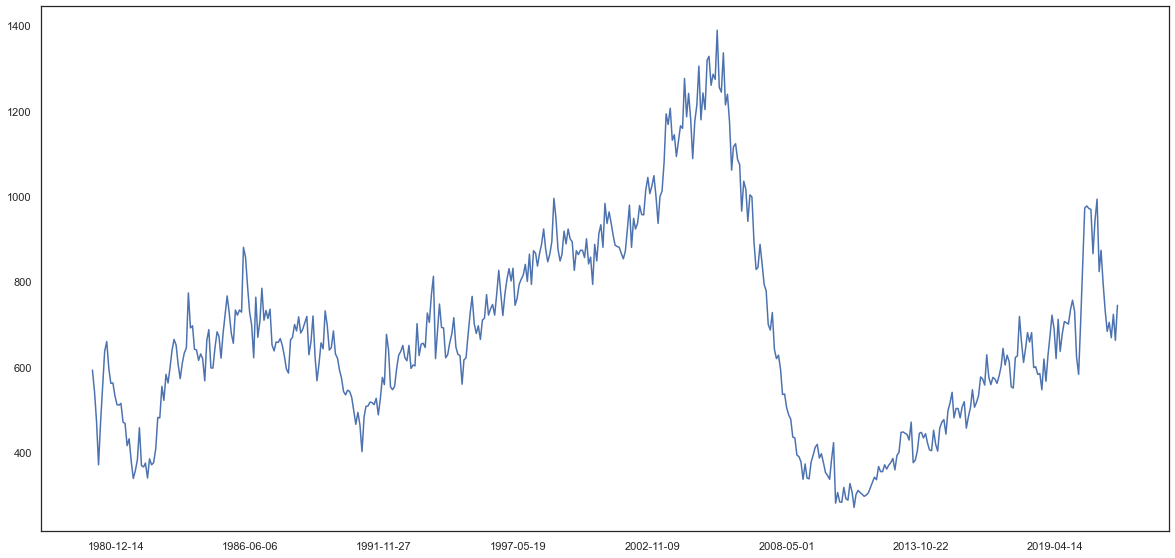

In [33]:
fig, ax = plt.subplots()
ax.plot(hsn1f.index.values, hsn1f['HSN1F'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

### Treasury Yield
#### Use Quandl

In [34]:
filename = '../data/MarketData/Quandl/USTREASURY_YIELD.csv'

treasury_q = pd.read_csv(filename, header=0)

treasury_q = treasury_q.set_index(pd.to_datetime(treasury_q['Date'], format="%Y-%m-%d")).drop(columns=['Date'])
treasury_q


,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,30 YR
Date,,,,,,,,,,,,
1990-01-02,NaN,NaN,7.83,7.89,7.81,7.87,7.90,7.87,7.98,7.94,NaN,8.00
1990-01-03,NaN,NaN,7.89,7.94,7.85,7.94,7.96,7.92,8.04,7.99,NaN,8.04
1990-01-04,NaN,NaN,7.84,7.90,7.82,7.92,7.93,7.91,8.02,7.98,NaN,8.04
1990-01-05,NaN,NaN,7.79,7.85,7.79,7.90,7.94,7.92,8.03,7.99,NaN,8.06
1990-01-08,NaN,NaN,7.79,7.88,7.81,7.90,7.95,7.92,8.05,8.02,NaN,8.09
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-13,0.05,0.05,0.12,0.28,0.47,0.91,1.18,1.47,1.64,1.70,2.10,2.05
2022-01-14,0.05,0.05,0.13,0.30,0.51,0.99,1.26,1.55,1.72,1.78,2.18,2.12
2022-01-18,0.05,0.06,0.16,0.37,0.58,1.06,1.35,1.65,1.82,1.87,2.24,2.18


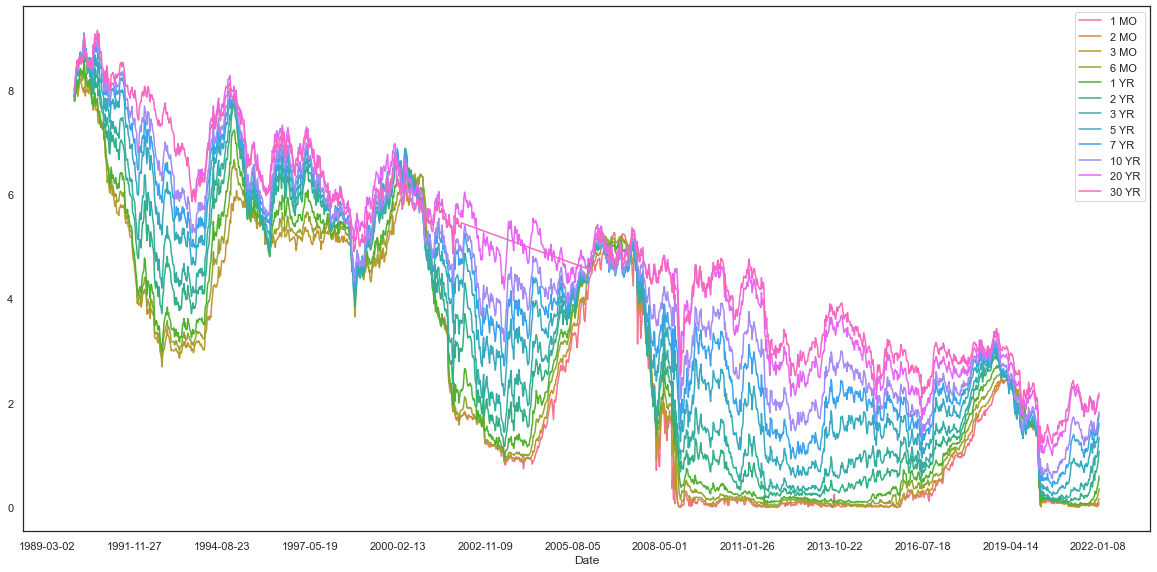

In [35]:
# Use every 5th row as it has too many data points
treasury_q_5 = treasury_q.iloc[::5, :]

fig, ax = plt.subplots()
ax = sns.lineplot(data = treasury_q_5, dashes=False)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1000))
plt.show()

# Process the data

## Add Rate and Decisions

In [36]:
# The target range was changed a couple of days after the announcement in the past,
#  while it is immediately put in effect on the day recently.
# Use the target rate three days after the meeting as target announced,
#  compare it with previous day's rate to check if rate has been changed.
#   -1: Rate lower
#    0: No change
#   +1: Rate hike

rate_list = []
decision_list = []
rate_diff_list = []

for i in tqdm(range(len(fomc_calendar))):
    not_found = True
    for j in range(len(fedrate_df)):
        if fomc_calendar.index[i] == fedrate_df.index[j]:
            not_found = False
            rate_list.append(float(fedrate_df['Rate'].iloc[j+3]))
            rate_diff_list.append(float(fedrate_df['Rate'].iloc[j+3]) - float(fedrate_df['Rate'].iloc[j-1]))
            if fedrate_df['Rate'].iloc[j-1] == fedrate_df['Rate'].iloc[j+3]:
                decision_list.append(0)
            elif fedrate_df['Rate'].iloc[j-1] < fedrate_df['Rate'].iloc[j+3]:
                decision_list.append(1)
            elif fedrate_df['Rate'].iloc[j-1] > fedrate_df['Rate'].iloc[j+3]:
                decision_list.append(-1)
            break
    if not_found:
        rate_list.append(np.nan)
        decision_list.append(np.nan)
        rate_diff_list.append(np.nan)

fomc_calendar.loc[:,'Rate'] = rate_list
fomc_calendar.loc[:,'RateDiff'] = rate_diff_list
fomc_calendar.loc[:,'RateDecision'] = decision_list
fomc_calendar['RateDecision'] = fomc_calendar['RateDecision'].astype('Int8')

fomc_calendar

  0%|          | 0/403 [00:00<?, ?it/s]

/Users/akalodzitsa/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/var/folders/mb/399h735x1zs3yswdfj_tqm68jcd560/T/ipykernel_13013/2190436413.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fomc_calendar['RateDecision'] = fomc_calendar['RateDecision'].astype('Int8')


,unscheduled,forecast,confcall,Rate,RateDiff,RateDecision
date,,,,,,
1982-10-05,False,False,False,9.5,-0.5,-1
1982-11-16,False,False,False,9.0,-0.5,-1
1982-12-21,False,False,False,8.5,0.0,0
1983-01-14,False,False,True,8.5,0.0,0
1983-01-21,False,False,True,8.5,0.0,0
...,...,...,...,...,...,...
2022-06-15,False,True,False,NaN,NaN,<NA>
2022-07-27,False,False,False,NaN,NaN,<NA>
2022-09-21,False,True,False,NaN,NaN,<NA>


In [37]:
fomc_calendar.loc[fomc_calendar['Rate'].isnull()]

,unscheduled,forecast,confcall,Rate,RateDiff,RateDecision
date,,,,,,
2022-01-26,False,False,False,NaN,NaN,<NA>
2022-03-16,False,True,False,NaN,NaN,<NA>
2022-05-04,False,False,False,NaN,NaN,<NA>
2022-06-15,False,True,False,NaN,NaN,<NA>
2022-07-27,False,False,False,NaN,NaN,<NA>
2022-09-21,False,True,False,NaN,NaN,<NA>
2022-11-02,False,False,False,NaN,NaN,<NA>
2022-12-14,False,True,False,NaN,NaN,<NA>


In [38]:
# Remove the future date
fomc_calendar = fomc_calendar.loc[fomc_calendar.index < dt.datetime.now()]

# Confirm no null rate remains
fomc_calendar.loc[fomc_calendar['Rate'].isnull()]

,unscheduled,forecast,confcall,Rate,RateDiff,RateDecision
date,,,,,,


In [39]:
# # Calculate the next business day (not used for now)
# from pandas.tseries.holiday import USFederalHolidayCalendar
# cal = USFederalHolidayCalendar()
# holidays = cal.holidays(start='1982-01-01', end='2020-12-31').strftime('%Y-%m-%d')
# bdd = np.busdaycalendar(weekmask='1111100', holidays=holidays)

# np.busday_offset('2011-01-01', np.arange(366), roll='forward', busdaycal=bdd)
# np.busday_offset('1982-10-06', 0, roll='forward', busdaycal=bdd)

Though this is not perfect as Target Rate was sometimes changed between FOMC meetings, enough to analyze the impact of FOMC Meetings.

## Add Quantitative Easing as a Lower event
Between 2008 and 2016 saw zero interest rate. Main monetary measure shifted to quantity from rate. Thus, add "lower" events when those QE was announced.

In [40]:
# Add 2008-11-25 to fomc_calendar when QE was first announced but not in FOMC Calendar
# Mark RateDecision = -1 (lower) even when rate is not changed but additional quantitative measures were announced

# QE1 Announced
rec_20081125 = pd.Series([True, False, False, 'Ben Bernanke', 0, -1, -1], index=['unscheduled', 'forecast', 'confcall', 'ChairPerson', 'Rate', 'RateDiff', 'RateDecision'], name=dt.datetime.strptime('2008-11-25', '%Y-%m-%d'))

if fomc_calendar.loc[fomc_calendar.index == dt.datetime.strptime('2008-11-25', '%Y-%m-%d')].shape[0] == 0:
    fomc_calendar = fomc_calendar.append(rec_20081125)

# Make the other timings of QE Expansion lowering events (consider the effect as -0.5%)
fomc_calendar.loc[fomc_calendar.index == dt.datetime(2009,3,18), ['RateDecision', 'RateDiff']] = (-1, -0.5) # QE1 Expanded
fomc_calendar.loc[fomc_calendar.index == dt.datetime(2010,11,3), ['RateDecision', 'RateDiff']] = (-1, -0.5) # QE2 Announced
fomc_calendar.loc[fomc_calendar.index == dt.datetime(2011,9,21), ['RateDecision', 'RateDiff']] = (-1, -0.5) # Operation Twist Announced
fomc_calendar.loc[fomc_calendar.index == dt.datetime(2012,6,20), ['RateDecision', 'RateDiff']] = (-1, -0.5) # Operation Twist Extended
fomc_calendar.loc[fomc_calendar.index == dt.datetime(2012,9,13), ['RateDecision', 'RateDiff']] = (-1, -0.5) # QE3 Announced
fomc_calendar.loc[fomc_calendar.index == dt.datetime(2012,12,12), ['RateDecision', 'RateDiff']] = (-1, -0.5) # QE3 Expanded

# It was announced QE ends - regard this as hike
fomc_calendar.loc[fomc_calendar.index == dt.datetime(2013,6,19), ['RateDecision', 'RateDiff']] = (1, 1) # Tapering Announced
fomc_calendar.loc['2013-12-18', ['RateDecision', 'RateDiff']] = (1, 1) # Tapering Begins
fomc_calendar.loc['2014-10-29', ['RateDecision', 'RateDiff']] = (1, 0.5) # QE3 Terminated
fomc_calendar.loc['2017-06-14', ['RateDecision', 'RateDiff']] = (1, 0.5) # Signaled Balance Sheet Normalization
fomc_calendar.loc['2017-09-20', ['RateDecision', 'RateDiff']] = (1, 0.5) # Stated Balance Sheet Normalization Begins in Oct
fomc_calendar.sort_index(ascending=True, inplace=True)
fomc_calendar


,unscheduled,forecast,confcall,Rate,RateDiff,RateDecision,ChairPerson
date,,,,,,,
1982-10-05,False,False,False,9.5,-0.5,-1,NaN
1982-11-16,False,False,False,9.0,-0.5,-1,NaN
1982-12-21,False,False,False,8.5,0.0,0,NaN
1983-01-14,False,False,True,8.5,0.0,0,NaN
1983-01-21,False,False,True,8.5,0.0,0,NaN
...,...,...,...,...,...,...,...
2021-06-16,False,True,False,0.0,0.0,0,NaN
2021-07-28,False,False,False,0.0,0.0,0,NaN
2021-09-22,False,True,False,0.0,0.0,0,NaN


In [41]:
# Add binary column to see if rate is changed
fomc_calendar['RateChanged'] = fomc_calendar['RateDecision'].apply(lambda x: 0 if x == 0 else 1)


<AxesSubplot:xlabel='date', ylabel='RateDecision'>

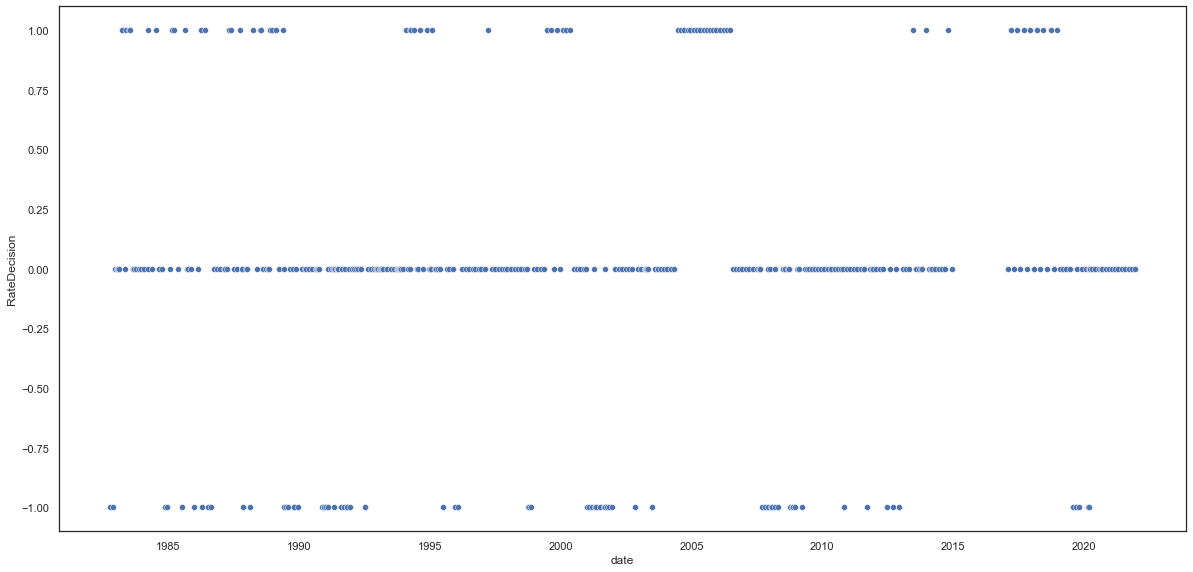

In [42]:
sns.scatterplot(x=fomc_calendar.index, y=fomc_calendar['RateDecision'].apply(lambda x: float(x)))

## Add major economic indices

In [43]:
def get_available_latest(train_df, index_df, value_col, diff_prev_col, diff_year_col, date_offset):
    '''
    Returns the latest available ecoonmic index for each row of train_df
    INPUTS:
        train_df: Index must be in datetime format
        idex_df: Index must be in datetime format
        value_col: The column name of the value in index_df
        diff_prev_col: The column name of the difference from previous period in index_df
        diff_year_col: The column name of the difference from the same priod in previous year in index_df
        date_offset: Use relativedelta for the offset when the index is published
    OUTPUTS:
        date_list: List of date matched with train_df.index
        value_list: List of values for the date_list
        diff_list: List of diff values for the date_list
    '''
    
    date_list, value_list, diff_prev_list, diff_year_list = [], [], [], []
    
    for i, row_data in tqdm(train_df.iterrows(), total=train_df.shape[0]):
        #print(row_data.name)
        not_available = True
        for j, row_index in index_df.sort_index(ascending=False).iterrows():
            if row_data.name > row_index.name + date_offset:
                #print("   matched: ", row_index.name)
                date_list.append(row_index.name)
                value_list.append(row_index[value_col])
                diff_prev_list.append(row_index[diff_prev_col])
                diff_year_list.append(row_index[diff_year_col])
                not_available = False
                break
        if not_available:
            date_list.append(None)
            value_list.append(None)
            diff_prev_list.append(None)
            diff_year_list.append(None)
    if train_df.shape[0] != len(date_list):
        print("train_df has {} rows but returned {} rows from index_df!".format(train_df.shape[0], len(date_list)))
    
    return date_list, value_list, diff_prev_list, diff_year_list

In [44]:
def add_market_data(calendar_df, window=1):
    '''
    Search the latest available market data using get_available_latest and retun a new dataframe with the market data.
    Moving average is applied to market data for the give window size.
    '''
    # First copy the caleander dataframe and drop Rate is NaN because this is the answer
    df = calendar_df.copy(deep=True)
    df.dropna(subset=['Rate'], inplace=True)
    
    # GDP is announced quarterly, the end of following month (preliminary)
    print("Processing GDP...")
    df['GDP_date'], df['GDP_value'], df['GDP_diff_prev'], df['GDP_diff_year'] \
    = get_available_latest(df, gdpc1.rolling(window).mean(), 'GDPC1', 'diff_prev', 'diff_year', relativedelta(months=+4, days=-2))

    print("Processing Potential GDP...")
    df['GDPPOT_date'], df['GDPPOT_value'], df['GDPPOT_diff_prev'], df['GDPPOT_diff_year'] \
    = get_available_latest(df, gdppot.rolling(window).mean(), 'GDPPOT', 'diff_prev', 'diff_year', relativedelta(months=+4, days=-2))

    # PCE is announced monthly, at the end of following month
    print("Processing PCE...")
    df['PCE_date'], df['PCE_value'], df['PCE_diff_prev'], df['PCE_diff_year'] \
    = get_available_latest(df, pcepilfe.rolling(window).mean(), 'PCEPILFE', 'diff_prev', 'diff_year', relativedelta(months=+2, days=-1))

    # CPI is announced monthly, around 10th of the following month
    print("Processing CPI...")
    df['CPI_date'], df['CPI_value'], df['CPI_diff_prev'], df['CPI_diff_year'] \
    = get_available_latest(df, cpiaucsl.rolling(window).mean(), 'CPIAUCSL', 'diff_prev', 'diff_year', relativedelta(months=+1, days=+9))

    # Employment statistics is announced monthly, around 3rd of the following month
    print("Processing Unemployemnt...")
    df['Unemp_date'], df['Unemp_value'], df['Unemp_diff_prev'], df['Unemp_diff_year'] \
    = get_available_latest(df, unrate.rolling(window).mean(), 'UNRATE', 'diff_prev', 'diff_year', relativedelta(months=+1, days=+2))

    # Employment statistics is announced monthly, around 3rd of the following month
    print("Processing Employment...")
    df['Employ_date'], df['Employ_value'], df['Employ_diff_prev'], df['Employ_diff_year'] \
    = get_available_latest(df, payems.rolling(window).mean(), 'PAYEMS', 'diff_prev', 'diff_year', relativedelta(months=+1, days=+2))

    # ISM PMI is areannounced monthly, around 1st of the following month
    print("Processing ISM PMI...")
    df['PMI_date'], df['PMI_value'], df['PMI_diff_prev'], df['PMI_diff_year'] \
    = get_available_latest(df, ism_pmi.rolling(window).mean(), 'PMI', 'diff_prev', 'diff_year', relativedelta(months=+1, days=+2))

    # ISM NMI is areannounced monthly, around 1st of the following month
    print("Processing ISM NMI...")
    df['NMI_date'], df['NMI_value'], df['NMI_diff_prev'], df['NMI_diff_year'] \
    = get_available_latest(df, ism_nmi.rolling(window).mean(), 'NMI', 'diff_prev', 'diff_year', relativedelta(months=+1, days=+2))

    # Retail Sales is announced monthly, around 15th of the following month
    print("Processing Retail Sales...")
    df['Rsales_date'], df['Rsales_value'], df['Rsales_diff_prev'], df['Rsales_diff_year'] \
    = get_available_latest(df, rrsfs.rolling(window).mean(), 'RRSFS', 'diff_prev', 'diff_year', relativedelta(months=+1, days=+2))

    # New Home Sales is announced monthly, around a week before the end of the following month
    print("Processing New Home Sales...")
    df['Hsales_date'], df['Hsales_value'], df['Hsales_diff_prev'], df['Hsales_diff_year'] \
    = get_available_latest(df, hsn1f.rolling(window).mean(), 'HSN1F', 'diff_prev', 'diff_year', relativedelta(months=+1, days=+2))
    
    return df

In [45]:
nontext_data = add_market_data(fomc_calendar)

Processing GDP...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing Potential GDP...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing PCE...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing CPI...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing Unemployemnt...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing Employment...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing ISM PMI...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing ISM NMI...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing Retail Sales...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing New Home Sales...


  0%|          | 0/396 [00:00<?, ?it/s]

In [46]:
nontext_ma2 = add_market_data(fomc_calendar, 2)
nontext_ma3 = add_market_data(fomc_calendar, 3)
nontext_ma6 = add_market_data(fomc_calendar, 6)
nontext_ma12 = add_market_data(fomc_calendar, 12)

Processing GDP...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing Potential GDP...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing PCE...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing CPI...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing Unemployemnt...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing Employment...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing ISM PMI...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing ISM NMI...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing Retail Sales...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing New Home Sales...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing GDP...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing Potential GDP...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing PCE...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing CPI...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing Unemployemnt...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing Employment...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing ISM PMI...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing ISM NMI...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing Retail Sales...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing New Home Sales...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing GDP...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing Potential GDP...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing PCE...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing CPI...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing Unemployemnt...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing Employment...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing ISM PMI...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing ISM NMI...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing Retail Sales...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing New Home Sales...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing GDP...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing Potential GDP...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing PCE...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing CPI...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing Unemployemnt...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing Employment...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing ISM PMI...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing ISM NMI...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing Retail Sales...


  0%|          | 0/396 [00:00<?, ?it/s]

Processing New Home Sales...


  0%|          | 0/396 [00:00<?, ?it/s]

## Add Taylor Rule
After EDA in Notebook No.4, it was found the individual economic index data has little to do with the rate decision. As FED has released how policymakers use these data here, try to calculate them and use instead of raw data. <BR />
https://www.federalreserve.gov/monetarypolicy/policy-rules-and-how-policymakers-use-them.htm

In [47]:
# Create taylor dataframe
taylor = fedrate_df.copy(deep=True)

# Obtain available index used to calculate Taylor rule each day
_, taylor['Y'],_,_ = get_available_latest(taylor, gdpc1, 'GDPC1', 'diff_prev', 'diff_year', relativedelta(months=+4, days=-2))
_, taylor['Yp'],_,_ = get_available_latest(taylor, gdppot, 'GDPPOT', 'diff_prev', 'diff_year', relativedelta(months=+4, days=-2))
taylor['Y-Yp'] = (np.log(taylor['Y']*10**9) - np.log(taylor['Yp']*10**9)) * 100

_, _,_, taylor['Pi'] = get_available_latest(taylor, pcepilfe, 'PCEPILFE', 'diff_prev', 'diff_year', relativedelta(months=+2, days=-1))
taylor['Pi*'] = 2
taylor['Pi-Pi*'] = taylor['Pi'] - taylor['Pi*']

taylor['r'] = 2


  0%|          | 0/14360 [00:00<?, ?it/s]

  0%|          | 0/14360 [00:00<?, ?it/s]

  0%|          | 0/14360 [00:00<?, ?it/s]

In [48]:
# Calculate Taylor Rule
taylor['Taylor'] = taylor['r'] + taylor['Pi'] + 0.5 * taylor['Pi-Pi*'] + 0.5 * taylor['Y-Yp']

# Calculate Balanced-approach Rule
taylor['Balanced'] = (taylor['r'] + taylor['Pi'] + 0.5 * taylor['Pi-Pi*'] + taylor['Y-Yp']).map(lambda x: 0 if x < 0 else x)

# Calculate Inertia Rule
taylor['Inertia'] = 0.85 * taylor['Rate'] - 0.15 * taylor['Balanced']

# Drop unnecessary columns
taylor = taylor.drop(columns = ['Y', 'Yp', 'Y-Yp', 'Pi', 'Pi*', 'Pi-Pi*', 'r', 'diff'])

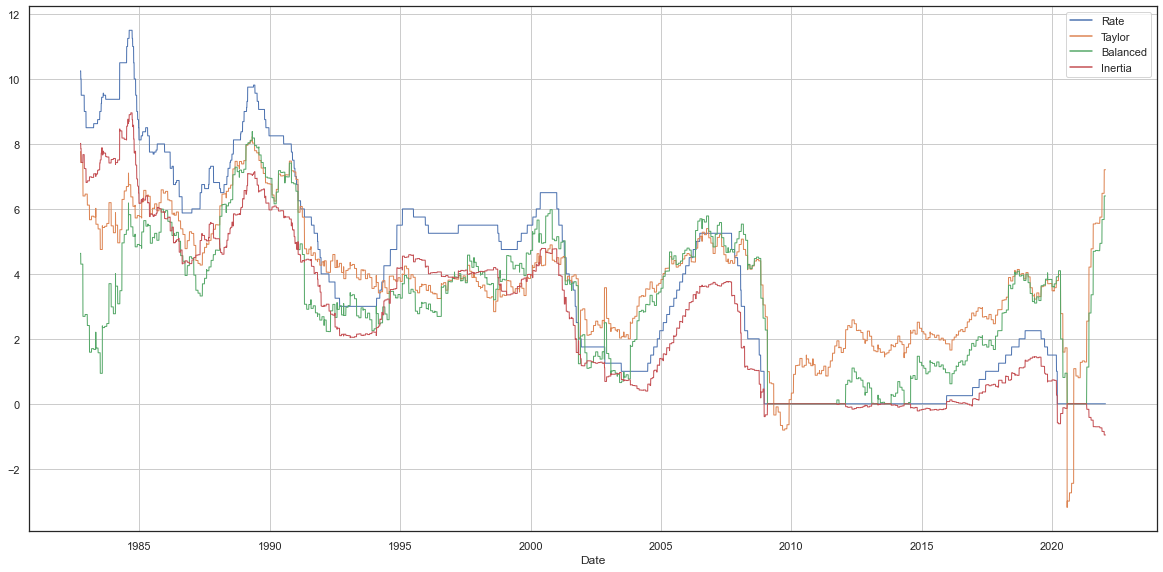

In [49]:
# Plot
# Use every 5th row as it has too many data points
# taylor_5 = taylor.iloc[::5, :]

fig, ax = plt.subplots()
ax = sns.lineplot(data=taylor, dashes=False, lw=1)
#ax.xaxis.set_major_locator(ticker.MultipleLocator(1000))
plt.grid(True)
plt.show()

In [50]:
# Deviation from Rate, which may trigger the rate change
taylor['Taylor-Rate'] = taylor['Taylor'] - taylor['Rate']
taylor['Balanced-Rate'] = taylor['Balanced'] - taylor['Rate']
taylor['Inertia-Rate'] = taylor['Inertia'] - taylor['Rate']

taylor['Taylor_diff'] = taylor['Taylor'].diff(1)
taylor['Balanced_diff'] = taylor['Balanced'].diff(1)
taylor['Inertia_diff'] = taylor['Inertia'].diff(1)

taylor

,Rate,Taylor,Balanced,Inertia,Taylor-Rate,Balanced-Rate,Inertia-Rate,Taylor_diff,Balanced_diff,Inertia_diff
Date,,,,,,,,,,
1982-09-27,10.25,7.761471,4.633424,8.017486,-2.488529,-5.616576,-2.232514,NaN,NaN,NaN
1982-09-28,10.25,7.761471,4.633424,8.017486,-2.488529,-5.616576,-2.232514,0.000000,0.000000,0.000000
1982-09-29,10.25,7.761471,4.633424,8.017486,-2.488529,-5.616576,-2.232514,0.000000,0.000000,0.000000
1982-09-30,10.25,7.761471,4.633424,8.017486,-2.488529,-5.616576,-2.232514,0.000000,0.000000,0.000000
1982-10-01,10.00,7.428054,4.300007,7.854999,-2.571946,-5.699993,-2.145001,-0.333417,-0.333417,-0.162487
...,...,...,...,...,...,...,...,...,...,...
2022-01-15,0.00,7.205843,6.398876,-0.959831,7.205843,6.398876,-0.959831,0.000000,0.000000,0.000000
2022-01-16,0.00,7.205843,6.398876,-0.959831,7.205843,6.398876,-0.959831,0.000000,0.000000,0.000000
2022-01-17,0.00,7.205843,6.398876,-0.959831,7.205843,6.398876,-0.959831,0.000000,0.000000,0.000000


In [51]:
# Add the calculated values to the dataframe
def add_taylor(df, window=1):
    taylor_ma = taylor.rolling(window).mean()
    df['Taylor'] = df.index.map(lambda x: taylor_ma.loc[taylor_ma.index == x + relativedelta(days=-1), 'Taylor'].values[0])
    df['Balanced'] = df.index.map(lambda x: taylor_ma.loc[taylor_ma.index == x + relativedelta(days=-1), 'Balanced'].values[0])
    df['Inertia'] = df.index.map(lambda x: taylor_ma.loc[taylor_ma.index == x + relativedelta(days=-1), 'Inertia'].values[0])
    df['Taylor-Rate'] = df.index.map(lambda x: taylor_ma.loc[taylor_ma.index == x + relativedelta(days=-1), 'Taylor-Rate'].values[0])
    df['Balanced-Rate'] = df.index.map(lambda x: taylor_ma.loc[taylor_ma.index == x + relativedelta(days=-1), 'Balanced-Rate'].values[0])
    df['Inertia-Rate'] = df.index.map(lambda x: taylor_ma.loc[taylor_ma.index == x + relativedelta(days=-1), 'Inertia-Rate'].values[0])
    df['Taylor_diff'] = df['Taylor'].diff(1)
    df['Balanced_diff'] = df['Balanced'].diff(1)
    df['Inertia_diff'] = df['Inertia'].diff(1)
    
    

In [52]:
add_taylor(nontext_data)
add_taylor(nontext_ma2, 60)
add_taylor(nontext_ma3, 90)
add_taylor(nontext_ma6, 180)
add_taylor(nontext_ma12, 360)

In [53]:
fomc_calendar.index.get_level_values(0).values

array(['1982-10-05T00:00:00.000000000', '1982-11-16T00:00:00.000000000',
       '1982-12-21T00:00:00.000000000', '1983-01-14T00:00:00.000000000',
       '1983-01-21T00:00:00.000000000', '1983-01-28T00:00:00.000000000',
       '1983-02-09T00:00:00.000000000', '1983-03-29T00:00:00.000000000',
       '1983-04-29T00:00:00.000000000', '1983-05-24T00:00:00.000000000',
       '1983-06-23T00:00:00.000000000', '1983-07-13T00:00:00.000000000',
       '1983-08-23T00:00:00.000000000', '1983-09-08T00:00:00.000000000',
       '1983-10-04T00:00:00.000000000', '1983-11-15T00:00:00.000000000',
       '1983-12-20T00:00:00.000000000', '1984-01-31T00:00:00.000000000',
       '1984-03-20T00:00:00.000000000', '1984-03-27T00:00:00.000000000',
       '1984-05-22T00:00:00.000000000', '1984-07-17T00:00:00.000000000',
       '1984-08-21T00:00:00.000000000', '1984-10-02T00:00:00.000000000',
       '1984-11-07T00:00:00.000000000', '1984-12-18T00:00:00.000000000',
       '1985-01-18T00:00:00.000000000', '1985-02-13

In [54]:
fomc_calendar.loc['2020-06-10', 'Rate'] = 0
fomc_calendar.loc['2020-07-29', 'Rate'] = 0
fomc_calendar.loc['2020-06-10', 'RateDiff'] = 0
fomc_calendar.loc['2020-07-29', 'RateDiff'] = 0


## Save the train data

In [55]:
def save_data(df, file_name, dir_name='../data/preprocessed/'):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
        
    # Save results to a picke file
    file = open(dir_name + file_name + '.pickle', 'wb')
    pickle.dump(df, file)
    file.close()

    # Save results to a csv file
    df.to_csv(dir_name + file_name + '.csv', index=True)

In [56]:
# Save data
save_data(nontext_data, 'nontext_data')
save_data(nontext_ma2, 'nontext_ma2')
save_data(nontext_ma3, 'nontext_ma3')
save_data(nontext_ma6, 'nontext_ma6')
save_data(nontext_ma12, 'nontext_ma12')
save_data(treasury_q, 'treasury')
save_data(fomc_calendar, 'fomc_calendar')